### homework1：练习VGG精调案例

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


数据准备

In [2]:
from pathlib import Path

DATA_DIR = Path("..")
DATA_DIR1 = Path("../competitions/cifar-10/")
train_lables_file = DATA_DIR / "trainLabels.csv"
test_csv_file = DATA_DIR / "sampleSubmission.csv"  #测试集模板csv文件
train_folder = DATA_DIR1 / "train"
test_folder = DATA_DIR1 / "test"

#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]


def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
        #         lines = f.readlines()  为什么加[1:]，可以试这个
        #第一行不需要，因为第一行是标签
        lines = f.readlines()[1:]
    for line in lines:  #依次去取每一行
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = folder / f"{image_id}.png"
        results.append((image_full_path, label_str))  #得到对应图片的路径和分类
    return results


#解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
#打印
import pprint

pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[(PosixPath('../competitions/cifar-10/train/1.png'), 'frog'),
 (PosixPath('../competitions/cifar-10/train/2.png'), 'truck'),
 (PosixPath('../competitions/cifar-10/train/3.png'), 'truck'),
 (PosixPath('../competitions/cifar-10/train/4.png'), 'deer'),
 (PosixPath('../competitions/cifar-10/train/5.png'), 'automobile')]
[(PosixPath('../competitions/cifar-10/test/1.png'), 'cat'),
 (PosixPath('../competitions/cifar-10/test/2.png'), 'cat'),
 (PosixPath('../competitions/cifar-10/test/3.png'), 'cat'),
 (PosixPath('../competitions/cifar-10/test/4.png'), 'cat'),
 (PosixPath('../competitions/cifar-10/test/5.png'), 'cat')]
50000 300000


In [3]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                               filepath       class
0  ../competitions/cifar-10/train/1.png        frog
1  ../competitions/cifar-10/train/2.png       truck
2  ../competitions/cifar-10/train/3.png       truck
3  ../competitions/cifar-10/train/4.png        deer
4  ../competitions/cifar-10/train/5.png  automobile
                                   filepath       class
0  ../competitions/cifar-10/train/45001.png       horse
1  ../competitions/cifar-10/train/45002.png  automobile
2  ../competitions/cifar-10/train/45003.png        deer
3  ../competitions/cifar-10/train/45004.png  automobile
4  ../competitions/cifar-10/train/45005.png    airplane
                              filepath class
0  ../competitions/cifar-10/test/1.png   cat
1  ../competitions/cifar-10/test/2.png   cat
2  ../competitions/cifar-10/test/3.png   cat
3  ../competitions/cifar-10/test/4.png   cat
4  ../competitions/cifar-10/test/5.png   cat


In [4]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Cifar10Dataset(Dataset):
    df_map = {
        "train": train_df,
        "eval": valid_df,
        "test": test_df
    }
    label_to_idx = {label: idx for idx, label in enumerate(class_names)}  #将类别转换为数字
    idx_to_label = {idx: label for idx, label in enumerate(class_names)}  #将数字转换为类别

    def __init__(self, mode, transform=None):
        self.df = self.df_map.get(mode, None)
        if self.df is None:
            raise ValueError("mode should be one of train, val, test, but got {}".format(mode))

        self.transform = transform  #对图片进行变换，transform是一个函数

    def __getitem__(self, index):
        img_path, label = self.df.iloc[index]  #得到对应的图片路径和类别
        img = Image.open(img_path).convert('RGB')  #打开图片
        # # img 转换为 channel first
        # img = img.transpose((2, 0, 1))
        # transform
        img = self.transform(img)  #对图片进行变换
        # label 转换为 idx
        label = self.label_to_idx[label]
        return img, label  #返回图片和类别

    def __len__(self):
        return self.df.shape[0]


IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

transforms_train = transforms.Compose([
    # resize
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # random rotation 40
    transforms.RandomRotation(40),
    # horizaontal flip
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transforms_eval = transforms.Compose([
    # resize
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = Cifar10Dataset("train", transforms_train)
eval_ds = Cifar10Dataset("eval", transforms_eval)

In [5]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
# def cal_mean_std(ds):
#     mean = 0.
#     std = 0.
#     for img, _ in ds:
#         mean += img.mean(dim=(1, 2))
#         std += img.std(dim=(1, 2))
#     mean /= len(ds)
#     std /= len(ds)
#     return mean, std
#
# # 经过 normalize 后 均值为0，方差为1
# print(cal_mean_std(train_ds))

定义模型

In [7]:
class VGG(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )

        self.cls = nn.Linear(512, num_classes)

        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    @classmethod
    def from_pretrained(cls, ckpt_path, num_classes=10):
        state_dict = torch.load(ckpt_path, map_location="cpu", weigths_only=True)  #加载模型
        state_dict.pop("cls.weight")  #去掉最后一层的权重
        state_dict.pop("cls.bias")  #去掉最后一层的偏置

        model = cls(num_classes=num_classes)  #实例化模型
        # 将修改后的状态字典加载到新创建的模型实例中。参数strict=False表示在加载状态字典时，如果字典中存在模型不期望的键或缺少某些期望的键，将不会抛出错误。这在迁移学习中很有用，因为你可能希望覆盖或忽略一些权重。
        model.load_state_dict(state_dict, strict=False)  #加载模型参数

        return model

    def forward(self, x):
        features = self.model(x)
        return self.cls(features)


for key, value in VGG(len(class_names)).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

             model.0.weight             paramerters num: 864
              model.0.bias              paramerters num: 32
             model.2.weight             paramerters num: 9216
              model.2.bias              paramerters num: 32
             model.5.weight             paramerters num: 9216
              model.5.bias              paramerters num: 32
             model.7.weight             paramerters num: 9216
              model.7.bias              paramerters num: 32
            model.10.weight             paramerters num: 9216
             model.10.bias              paramerters num: 32
            model.12.weight             paramerters num: 9216
             model.12.bias              paramerters num: 32
               cls.weight               paramerters num: 5120
                cls.bias                paramerters num: 10


训练

In [8]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)  # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [9]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [10]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [11]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [12]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [13]:
epoch = 10
model = VGG(num_classes=10)  #第一次先训练，得到下面best.ckpt后，再注释这一条，用下面的加载模型
# model = VGG.from_pretrained("checkpoints/vgg-fine-tune/best.ckpt", num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Optimizers specified in the torch.optim package
# 微调（Fine-tuning）：在迁移学习或微调预训练模型时，这种方法特别有用。在这种情况下，你可能希望对模型的预训练部分（不包含"cls"的部分）使用较小的学习率，以避免破坏已经学到的特征。而对新添加的或需要特别训练的部分（如新的分类层，包含"cls"的部分）使用较高的学习率，以便更快地学习到特定任务的特征。
# optimizer = torch.optim.Adam(
#     [
#         {
#             "params": [value for key, value in model.named_parameters() if "cls" not in key],
#             "lr": 0.0001  # 卷积层用的是之前的预训练参数，不希望变化过大，所以学习率设为较小
#         },
#         {
#             "params": [value for key, value in model.named_parameters() if "cls" in key],
#             "lr": 0.0005  # 分类层是重新初始化的，可以用较大的学习率
#         },
#      ]
#     )
# 
exp_name = "vgg-fine-tune"

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
# tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")
# tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/{exp_name}", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

In [14]:
model = model.to(device)
record = training(
    model,
    train_dl,
    eval_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
)

100%|██████████| 7040/7040 [01:12<00:00, 96.90it/s, epoch=9] 


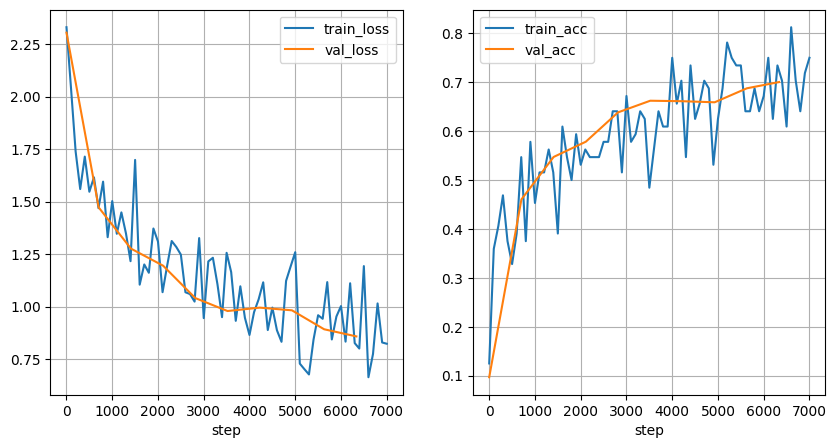

In [15]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=100)  #横坐标是 steps

评估

In [16]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/{exp_name}/best.ckpt", map_location="cpu", weights_only=True))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.8579
accuracy: 0.7004


微调

In [17]:
model = VGG.from_pretrained("checkpoints/vgg-fine-tune/best.ckpt", num_classes=10)
# Optimizers specified in the torch.optim package
# 微调（Fine-tuning）：在迁移学习或微调预训练模型时，这种方法特别有用。在这种情况下，你可能希望对模型的预训练部分（不包含"cls"的部分）使用较小的学习率，以避免破坏已经学到的特征。而对新添加的或需要特别训练的部分（如新的分类层，包含"cls"的部分）使用较高的学习率，以便更快地学习到特定任务的特征。
optimizer = torch.optim.Adam(
    [
        {
            "params": [value for key, value in model.named_parameters() if "cls" not in key],
            "lr": 0.0001  # 卷积层用的是之前的预训练参数，不希望变化过大，所以学习率设为较小
        },
        {
            "params": [value for key, value in model.named_parameters() if "cls" in key],
            "lr": 0.0005  # 分类层是重新初始化的，可以用较大的学习率
        },
    ]
)
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)
record = training(
    model,
    train_dl,
    eval_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
)

/tmp/ipykernel_574/712102131.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location="cpu")  #加载模型
100%|██████████| 7040/7040 [0

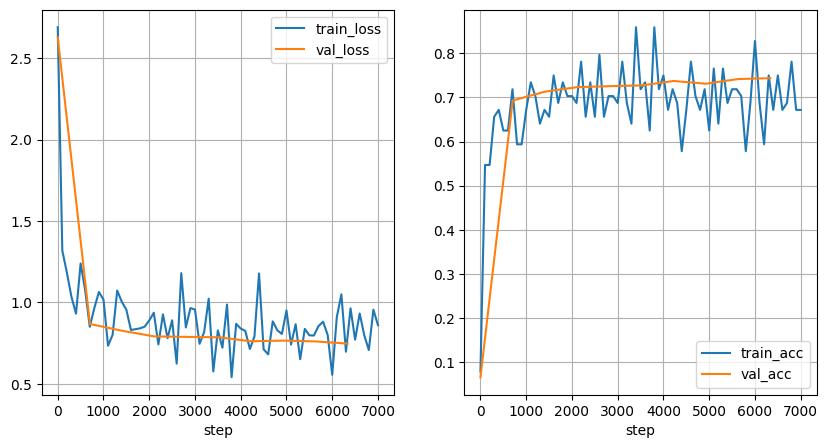

In [18]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=100)  #横坐标是 steps

评估

In [19]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/{exp_name}/best.ckpt", map_location="cpu", weights_only=True))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.7471
accuracy: 0.7438
